In [21]:
import cv2
import numpy as np
import time

filename = 'DATASETS/r3'
img = cv2.imread(filename+'.png')
#cv2.imshow('Maze', img)

# Binary conversion
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# Inverting tholdolding will give us a binary image with a white wall and a black background.
ret, thresh = cv2.threshold(gray, 127, 255, cv2.THRESH_BINARY_INV) 
cv2.imwrite(filename+'/1. Threshold1.jpg', thresh)
#cv2.imshow('Threshold 1', thresh)

# Contours
contours, hierarchy = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
dc = cv2.drawContours(thresh, contours, 0, (255, 255, 255), 5)
cv2.imwrite(filename+'/2. Contours1.jpg', dc)
#cv2.imshow('Contours 1', dc)

dc = cv2.drawContours(dc, contours, 1, (0,0,0) , 5)
cv2.imwrite(filename+'/3. Contours2.jpg', dc)
#cv2.imshow('Contours 2', dc)

ret, thresh = cv2.threshold(dc, 240, 255, cv2.THRESH_BINARY)
cv2.imwrite(filename+'/4. Threshold2.jpg', thresh)
#cv2.imshow('Threshold 2', thresh)

ke = 19
kernel = np.ones((ke, ke), np.uint8)

# Dilate
'''
Dilation is one of the two basic operators in the field of mathematical morphology, and the other is erosion.
It is usually applied to binary images, but there are some versions available for grayscale images.
The basic effect of the operator on binary images is to gradually enlarge the boundaries of foreground pixel regions (usually white pixels).
Therefore, the size of the foreground pixel increases, and the holes in these areas become smaller.
'''
dilation = cv2.dilate(thresh, kernel, iterations=1)
cv2.imwrite(filename+'/5. Dilation.jpg', dilation)
#cv2.imshow('Dilation', dilation)

# Erosion
'''
Erosion is a form of the second operator.
It also applies to binary images.
The basic effect of the operator on binary images is to eliminate the boundaries of foreground pixel areas (usually white pixels).
Therefore, the area of ​​foreground pixels is reduced, and the holes in these areas become large.
'''

erosion = cv2.erode(dilation, kernel, iterations=1)
cv2.imwrite(filename+'/6. Erosion.jpg', erosion)
#cv2.imshow('Erosion', erosion)

# Find differences between two images
diff = cv2.absdiff(dilation, erosion)
cv2.imwrite(filename+'/7. Difference.jpg', diff)
#cv2.imshow('Difference', diff)

# splitting the channels of maze
b, g, r = cv2.split(img)
mask_inv = cv2.bitwise_not(diff)
cv2.imwrite(filename+'/8. Mask.jpg', mask_inv)
#cv2.imshow('Mask', mask_inv)
#cv2.imshow('Mask', mask_inv)

# In order to display the solution on the original maze image, first divide the original maze into r, g, b components.
# Now create a mask by inverting the diff image.
# The bitwise and r and g components of the original maze using the mask created in the last step.
# This step will remove the red and green components from the image portion of the maze solution.
# The last one is to merge all the components and we will use the blue marked solution.

# masking out the green and red colour from the solved path
r = cv2.bitwise_and(r, r, mask=mask_inv)
b = cv2.bitwise_and(b, b, mask=mask_inv)

res = cv2.merge((b, g, r))
cv2.imwrite(filename+'/9. SolvedMaze.jpg', res)
cv2.imshow('Solved Maze', res)
cv2.waitKey(0)
cv2.destroyAllWindows()

Optimum route found.


<Figure size 1400x1400 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

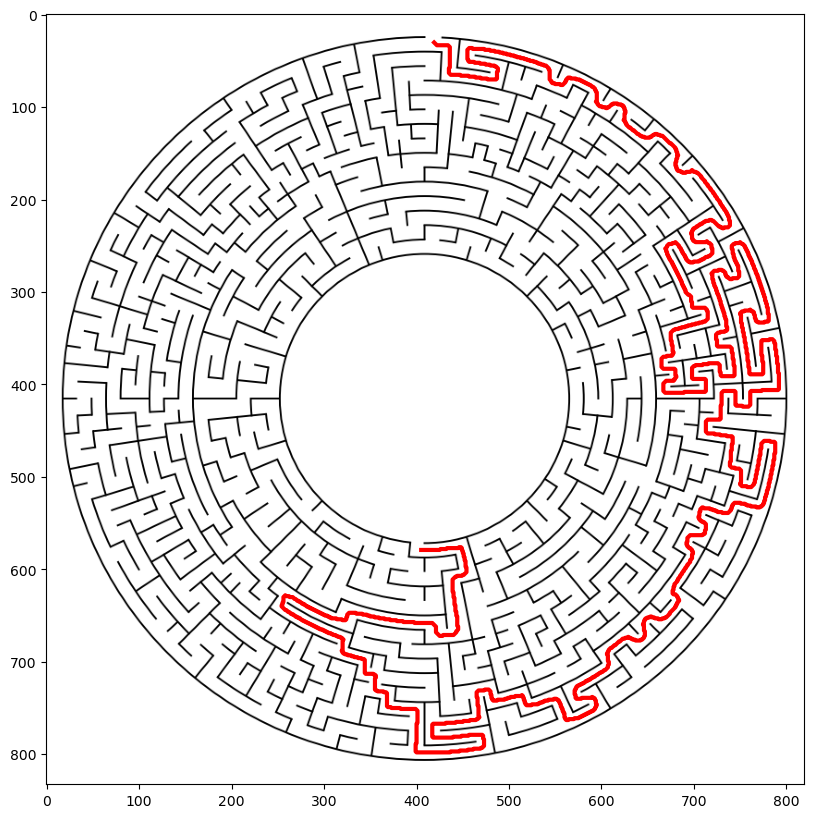

In [22]:
import matplotlib.pylab as plt # I use version 3.1.2
#Notes for installing skimage: https://scikit-image.org/docs/dev/install.html
from skimage.morphology import skeletonize # I use version 0.16.2
import numpy as np # I use version 1.18.1
img_name = 'DATASETS/cir3.png'
rgb_img = plt.imread(img_name)

plt.figure(figsize=(14,14))
#plt.imshow(rgb_img)
x0,y0 = 400,570 #start x point
x1,y1 = 420,20 #start y point

#plt.plot(x0,y0, 'gx', markersize = 14)
#plt.plot(x1,y1, 'rx', markersize = 14)

if rgb_img.shape.__len__()>2:
    thr_img = rgb_img[:,:,0] > np.max(rgb_img[:,:,0])/2
else:
    thr_img = rgb_img > np.max(rgb_img)/2
skeleton = skeletonize(thr_img)
plt.figure(figsize=(10,10))
#plt.imshow(skeleton)
#map of routes.
mapT = ~skeleton
#plt.imshow(mapT)
#plt.plot(x0,x0, 'gx', markersize=14)
#plt.plot(x1,y1, 'rx', markersize=14)

_mapt = np.copy(mapT)

#searching for our end point and connect to the path.
boxr = 10

#Just a little safety check, if the points are too near the edge, it will error.
if y1 < boxr: y1 = boxr
if x1 < boxr: x1 = boxr

cpys, cpxs = np.where(_mapt[y1-boxr:y1+boxr, x1-boxr:x1+boxr]==0)
#calibrate points to main scale.
cpys += y1-boxr
cpxs += x1-boxr
#find clooset point of possible path end points
idx = np.argmin(np.sqrt((cpys-y1)**2 + (cpxs-x1)**2))
y, x = cpys[idx], cpxs[idx]

pts_x = [x]
pts_y = [y]
pts_c = [0]

#mesh of displacements.
xmesh, ymesh = np.meshgrid(np.arange(-1,2),np.arange(-1,2))
ymesh = ymesh.reshape(-1)
xmesh = xmesh.reshape(-1)

dst = np.zeros((thr_img.shape))
while(True):
    #update distance.
    idc = np.argmin(pts_c)
    ct = pts_c.pop(idc)
    x = pts_x.pop(idc)
    y = pts_y.pop(idc)
    #Search 3x3 neighbourhood for possible
    ys,xs = np.where(_mapt[y-1:y+2,x-1:x+2] == 0)
    #Invalidate these point from future searchers.
    _mapt[ys+y-1, xs+x-1] = ct
    _mapt[y,x] = 9999999
    #set the distance in the distance image.
    dst[ys+y-1,xs+x-1] = ct+1
    #extend our list.s
    pts_x.extend(xs+x-1)
    pts_y.extend(ys+y-1)
    pts_c.extend([ct+1]*xs.shape[0])
    #If we run of points.
    if pts_x == []:
        break
    if np.sqrt((x-x0)**2 + (y-y0)**2) <boxr:
        edx = x
        edy = y
        break
plt.figure(figsize=(10,10))
#plt.imshow(dst)

path_x = []
path_y = [] 

y = edy
x = edx
#Traces best path
while(True):
    nbh = dst[y-1:y+2,x-1:x+2]
    nbh[1,1] = 9999999
    nbh[nbh==0] = 9999999
    #If we reach a deadend
    if np.min(nbh) == 9999999:
        break
    idx = np.argmin(nbh)
    #find direction
    y += ymesh[idx]
    x += xmesh[idx]
    
    if np.sqrt((x-x1)**2 + (y-y1)**2) < boxr:
        print('Optimum route found.')
        break
    path_y.append(y)
    path_x.append(x)
    
plt.figure(figsize=(10,10))
plt.imshow(rgb_img)
plt.plot(path_x,path_y, 'r-', linewidth=3)